In [1]:
import os
import sys 
from pyprojroot import here
sys.path.insert(0, str(here()))

import geopandas as gpd
from laos_gggi.data_functions import load_emdat_data, load_shapefile, load_rivers_data
from laos_gggi.plotting import configure_plot_style
from laos_gggi.statistics import get_distance_to_rivers
from laos_gggi.data_functions.combine_data import load_all_data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import arviz as az
import scipy

import pymc as pm
import pytensor.tensor as pt
from laos_gggi.sample import sample_or_load

configure_plot_style()

In [2]:
def load_data(fpath):
    data = pd.read_csv(fpath)
    data['geometry'] = gpd.points_from_xy(data.long, data.lat)
    data = gpd.GeoDataFrame(data, crs='EPSG:4326')
    
    return data

folder = 'data'
modified_data = False
fpath_1 = here(os.path.join(folder, 'disaster_locations_gpt_repaired_w_features.csv'))
fpath_2 = here(os.path.join(folder, 'disaster_locations_gpt_repaired.csv'))
if os.path.exists(fpath_1):
    data = load_data(fpath_1)
elif os.path.exists(fpath_2):
    data = load_data(fpath_2)
else:
    raise ValueError('Go run the GPT notebook first!')

In [3]:
emdat = load_emdat_data()

In [4]:
data = (data
            .set_index(['emdat_index'])
            .join(emdat['df_raw_filtered_adj'])
            .reset_index(drop=False)
            .rename(columns={'index':'emdat_index'})
            .set_index(['emdat_index', 'location_id'])
       )

In [5]:
data.head()

name      lat      long  \
emdat_index location_id                                                   
1908.0      0.0                                Benin   9.3076    2.3158   
1911.0      0.0                               Gambia  13.4432  -15.3101   
2018.0      0.0                   Asunción, Paraguay -25.2637  -57.5759   
            1.0                 Concepción, Paraguay -23.3847  -57.3801   
2019.0      0.0          Santa Cruz, Solomon Islands -10.6140  165.1761   

                         distance_to_river  ORD_FLOW  HYRIV_ID  \
emdat_index location_id                                          
1908.0      0.0                  89.271135         4  10695619   
1911.0      0.0                   1.126871         4  10507767   
2018.0      0.0                   3.558485         3  61380542   
            1.0                  10.299119         3  61352866   
2019.0      0.0                1607.259409         4  50337362   

                         distance_to_coastline  is_island  \
emdat_index location_id                                     
1908.0      0.0                     327.990440      False   
1911.0      0.0                      30.453084      False   
2018.0      0.0                     915.979862      False   
            1.0                     991.587343      False   
2019.0      0.0                      60.870846       True   

                                          geometry         DisNo.  ...  \
emdat_index location_id                                            ...   
1908.0      0.0              POINT (2.3158 9.3076)  1969-9006-BEN  ...   
1911.0      0.0           POINT (-15.3101 13.4432)  1969-9006-GMB  ...   
2018.0      0.0          POINT (-57.5759 -25.2637)  1971-0007-PRY  ...   
            1.0          POINT (-57.3801 -23.3847)  1971-0007-PRY  ...   
2019.0      0.0           POINT (165.1761 -10.614)  1971-0008-SLB  ...   

                        Reconstruction_Costs_Adjusted Insured_Damage  \
emdat_index location_id                                                
1908.0      0.0                                   NaN            NaN   
1911.0      0.0                                   NaN            NaN   
2018.0      0.0                                   NaN            NaN   
            1.0                                   NaN            NaN   
2019.0      0.0                                   NaN            NaN   

                        Insured_Damage_Adjusted Total_Damage  \
emdat_index location_id                                        
1908.0      0.0                             NaN          NaN   
1911.0      0.0                             NaN        200.0   
2018.0      0.0                             NaN         50.0   
            1.0                             NaN         50.0   
2019.0      0.0                             NaN          NaN   

                        Total_Damage_Adjusted        CPI Admin Units  \
emdat_index location_id                                                
1908.0      0.0                           NaN  13.723806         NaN   
1911.0      0.0                        1505.0  13.288956         NaN   
2018.0      0.0                         376.0  13.288956         NaN   
            1.0                         376.0  13.288956         NaN   
2019.0      0.0                           NaN  13.288956         NaN   

                         Entry Date Last Update       disaster_class  
emdat_index location_id                                               
1908.0      0.0          2006-11-24  2023-09-25       Climatological  
1911.0      0.0          2006-08-08  2023-09-25       Climatological  
2018.0      0.0          2003-07-01  2023-09-25  Hydrometereological  
            1.0          2003-07-01  2023-09-25  Hydrometereological  
2019.0      0.0          2003-07-01  2023-09-25                 None  

[5 rows x 56 columns]

In [6]:
world = load_shapefile('world')
laos = load_shapefile('laos')
coastline = load_shapefile('coastline')
rivers = load_rivers_data()

C:\Users\camil\AppData\Local\Temp\ipykernel_20704\3914288617.py:4: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  rivers = load_rivers_data()


<Axes: >

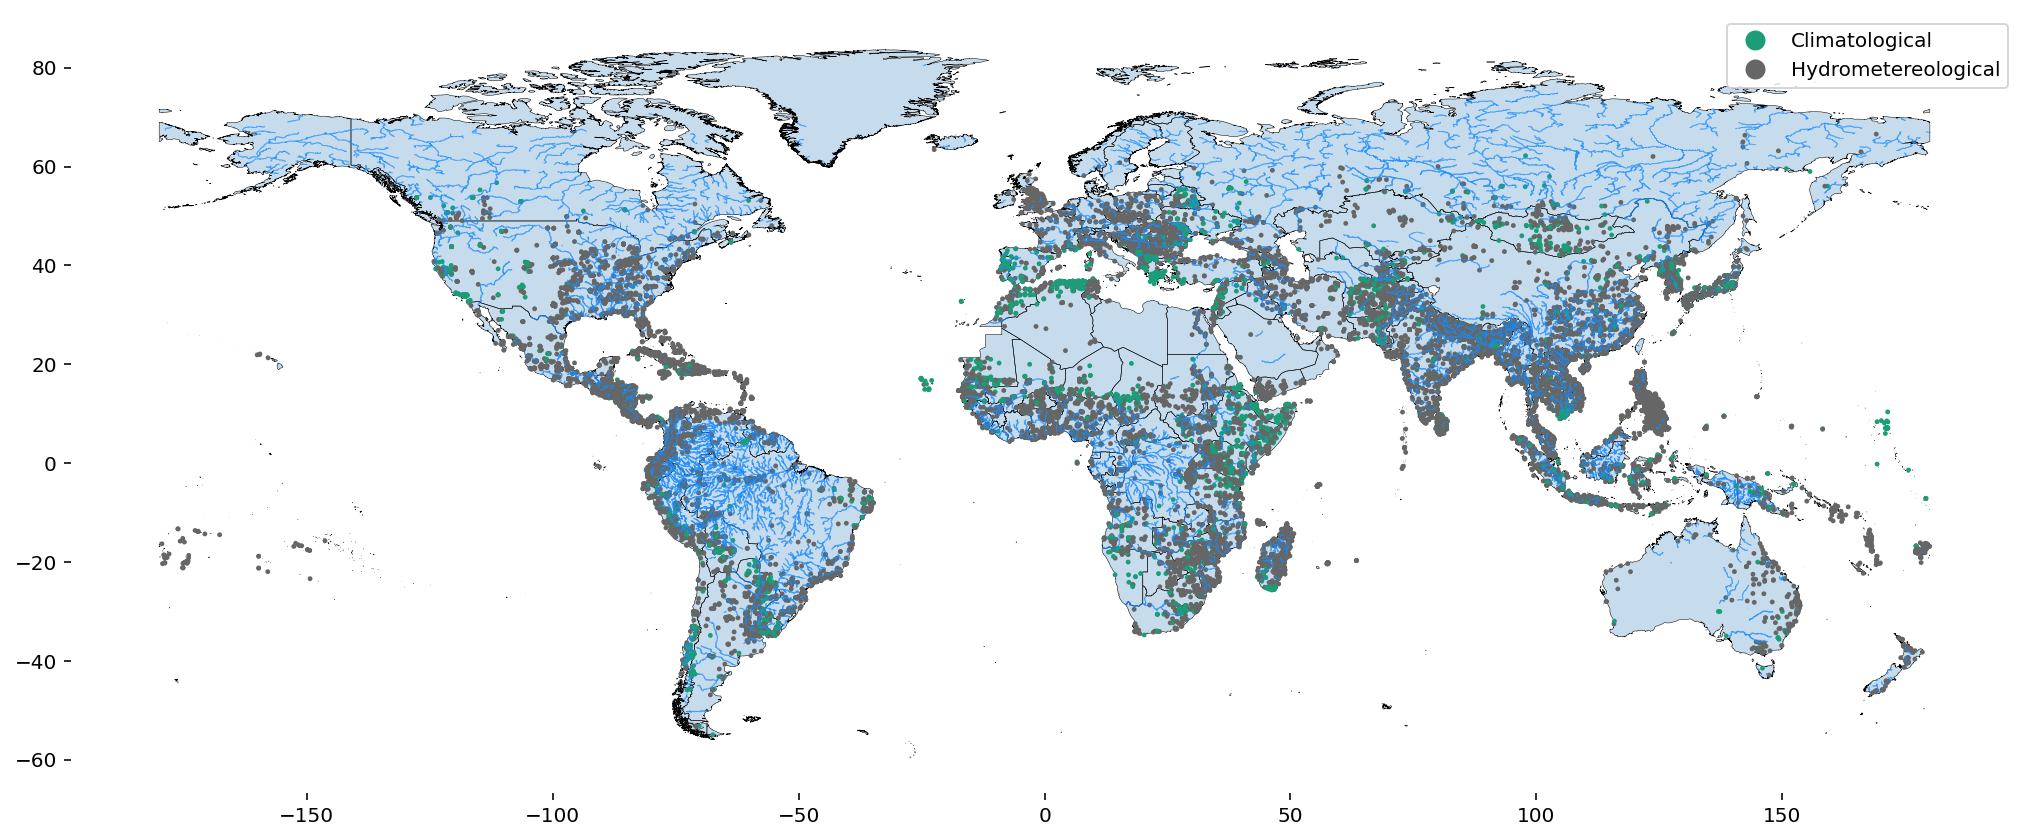

In [7]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)
data.dropna(subset='disaster_class').plot('disaster_class', markersize=2, ax=ax, legend=True, cmap='Dark2')

In [8]:
from joblib import Parallel, delayed
import pandas as pd
from tqdm.notebook import tqdm

def get_distance_to(gdf, points, return_columns=None, crs="EPSG:3395", n_cores=-1):
    if return_columns is None:
        return_columns = []
        
    gdf_km = gdf.copy().to_crs(crs)
    points_km = points.copy().to_crs(crs)
    
    def get_closest(idx, row, gdf_km, return_columns):
        series = gdf_km.distance(row.geometry)
        index = series[series == series.min()].index[0]

        ret_vals = (series.min(), )
        for col in return_columns:
            ret_vals += (gdf_km.loc[index][col], )
        
        return ret_vals
    
    with Parallel(n_cores, require='sharedmem') as pool:
        results = pool(delayed(get_closest)(idx, row, gdf_km, return_columns) for idx, row in tqdm(points_km.iterrows(), total=points.shape[0]))
    return pd.DataFrame(results, columns = ['distance_to_closest'] + return_columns, index=points.index)

In [9]:
if 'distance_to_river' not in data.columns:
    distances = get_distance_to(rivers, points=data, return_columns=['ORD_FLOW', 'HYRIV_ID']).rename(columns={'distance_to_closest':'distance_to_river'})
    data = data.join(distances).assign(distance_to_river = lambda x: x.distance_to_river / 1000)
    modified_data = True

<Axes: ylabel='Frequency'>

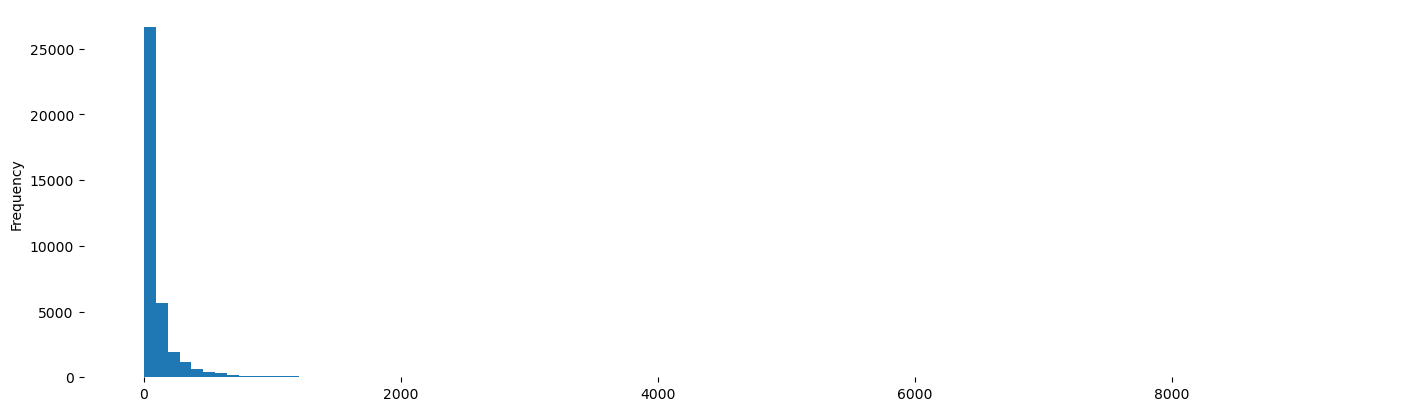

In [10]:
data.distance_to_river.plot.hist(bins=100)

In [11]:
if 'distance_to_coastline' not in data.columns:
    distances = get_distance_to(coastline.boundary, points=data.loc[:, ['geometry']]).rename(columns={'distance_to_closest':'distance_to_coastline'})
    data = data.join(distances).assign(distance_to_coastline = lambda x: x.distance_to_coastline / 1000)
    modified_data = True

<Axes: ylabel='Frequency'>

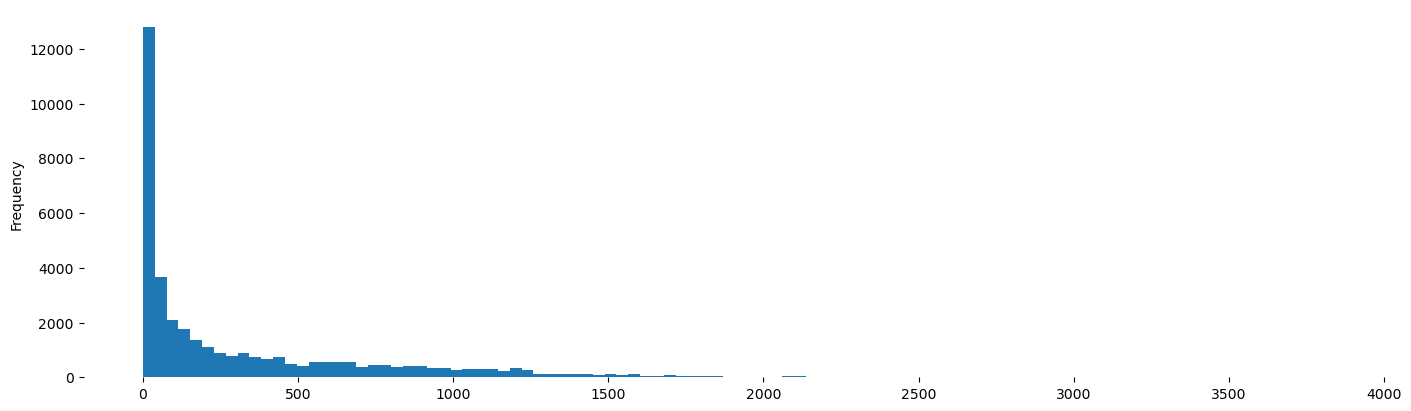

In [12]:
data.distance_to_coastline.plot.hist(bins=100)

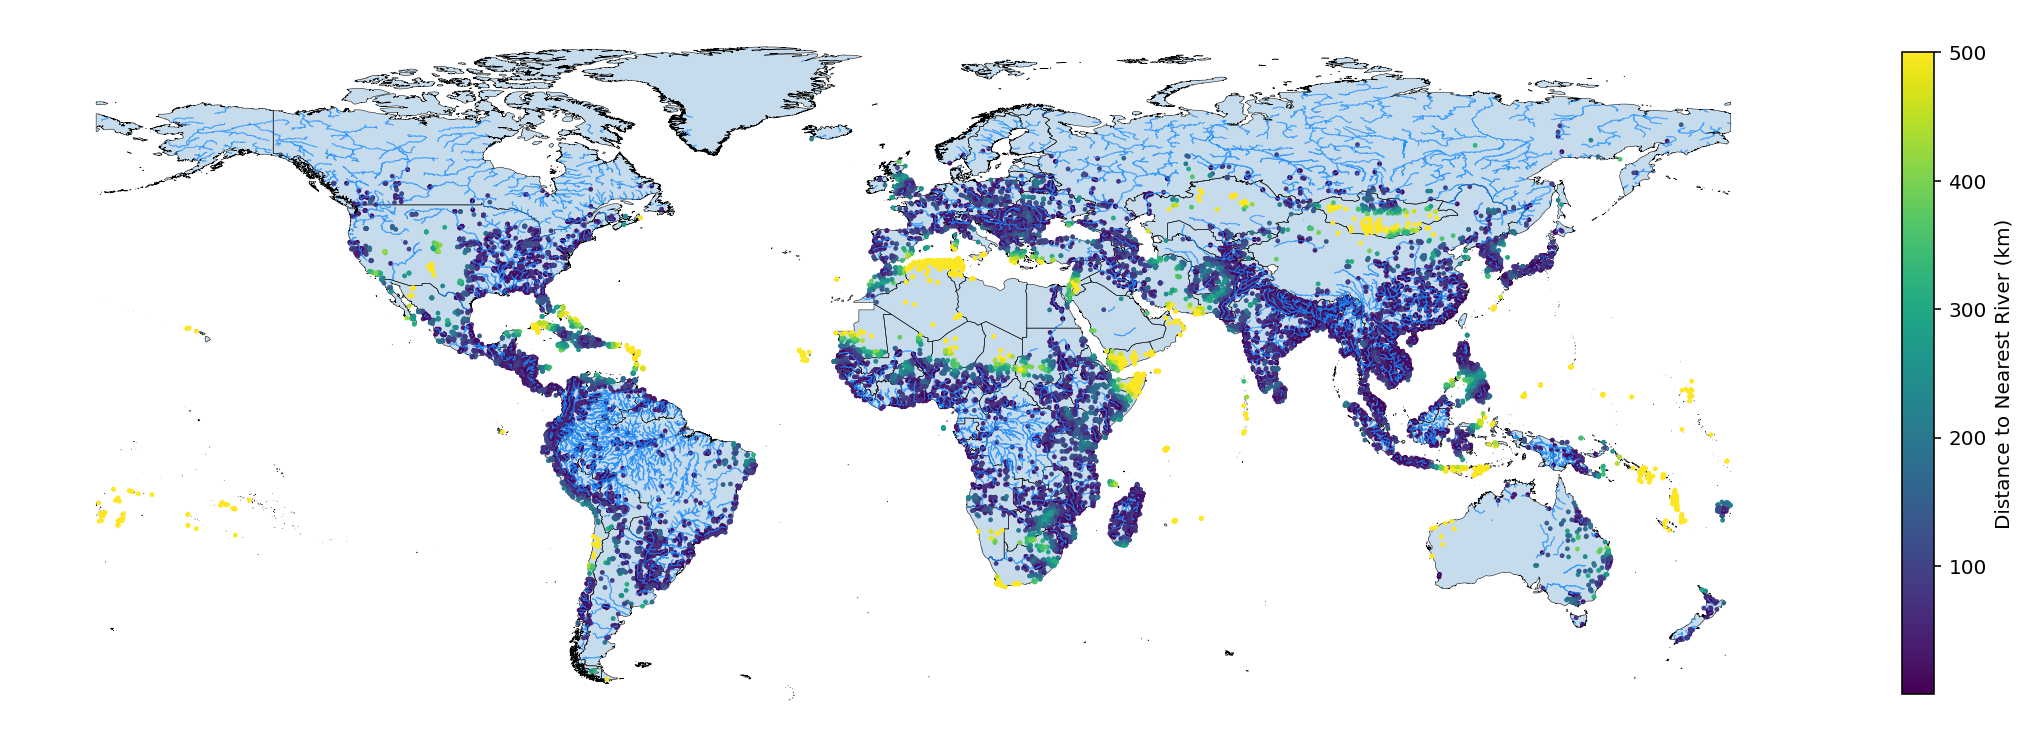

In [13]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)
data.dropna(subset='disaster_class').plot('distance_to_river', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      cmap='viridis', 
                                      vmax=500, 
                                      legend_kwds={'shrink':0.5, 'label':'Distance to Nearest River (km)'})
ax.axis('off')
plt.show()

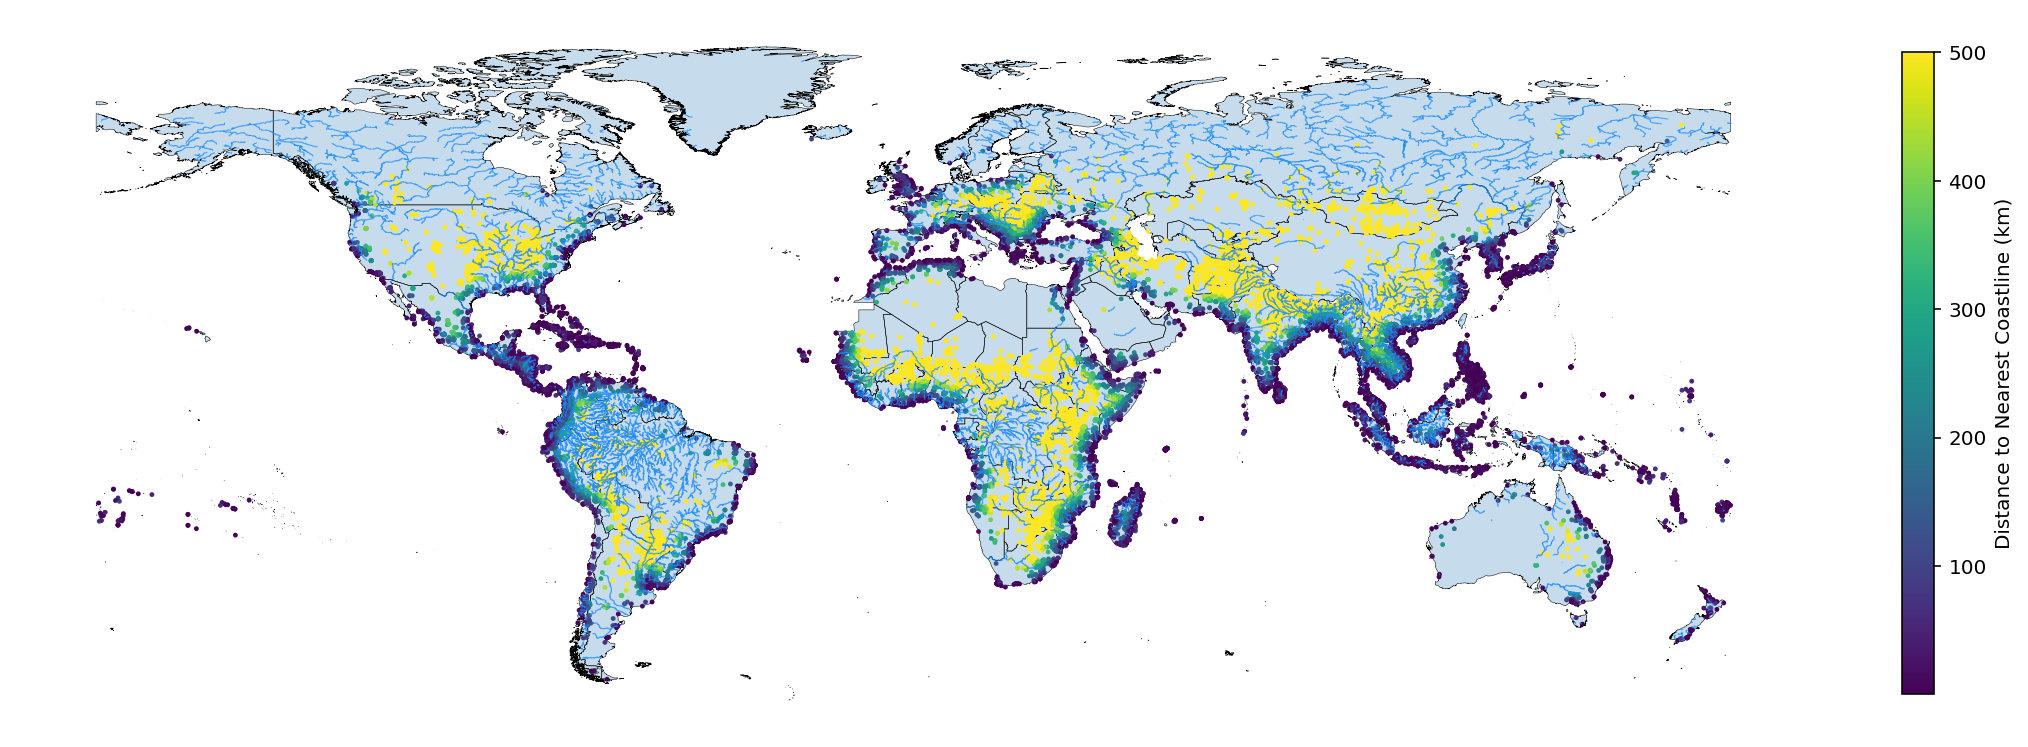

In [14]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)
data.dropna(subset='disaster_class').plot('distance_to_coastline', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      cmap='viridis', 
                                      vmax=500,
                                      legend_kwds={'shrink':0.5, 'label':'Distance to Nearest Coastline (km)'})
ax.axis('off')
plt.show()

In [15]:
if 'is_island' not in data.columns:
    try:
        import wikipedia as wp
    except ImportError:
        !mamba install wikipedia -q -y
        import wikipedia as wp

    html = wp.page("List_of_island_countries").html().encode("UTF-8")
    island_table = (pd.read_html(html, skiprows=0)[0]
                        .droplevel(axis=1, level=0)
                        .dropna(how='all').iloc[1:]
                        .reset_index(drop=True)
                        .assign(ISO_2 = lambda x: x['ISO code'].str.split().str[0],
                                ISO_3 = lambda x: x['ISO code'].str.split().str[1].replace({'or':'GBR'}))
                   )
    data['is_island'] = data.ISO.isin(island_table.ISO_3)
    modified_data = True

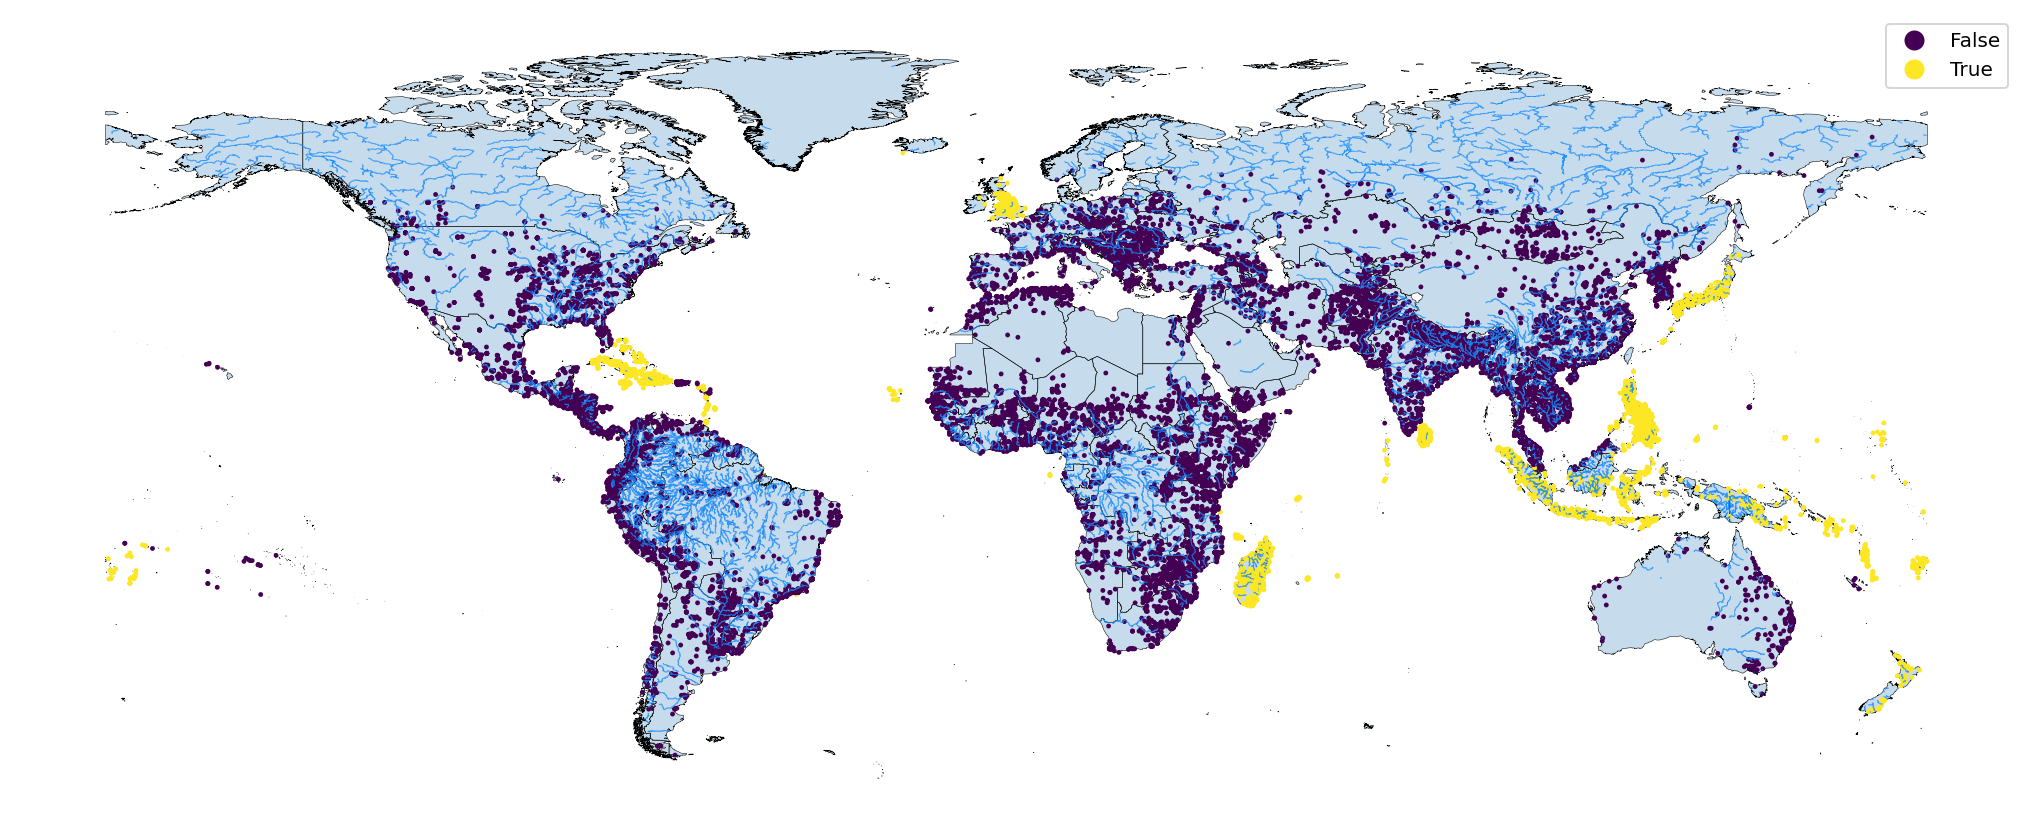

In [16]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)

data.dropna(subset='disaster_class').plot('is_island', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      categorical=True,
                                      cmap='viridis')
ax.axis('off')
plt.show()

In [17]:
if modified_data:
    (data
         .drop(columns=emdat['df_raw_filtered_adj'].columns.tolist() + ['geometry'])
         .to_csv(fpath_1))

# Synthetic Data

Create a bunch of dummy datapoints with geospatial features. These will be non-disasters. The model will need to distinguish the real disaster data from these fake points.

In [18]:
if not os.path.exists(here('data/synthetic_non_disasters.csv')):
    seed = sum(map(ord, 'Laos GGGI Climate Adaptation'))
    rng = np.random.default_rng(seed)

    # "Melt" the world into 5 regions - Americas, Europe, Asia, Afria, Oceania. This corresponds with the "Regions" column from EMDAT
    simple_world = (world
                        .replace({'North America':'Americas', 'South America':'Americas'})
                        .query('CONTINENT != "Seven seas (open ocean)"')
                        .dissolve('CONTINENT')
                        .loc[data.Region.unique()])

    # For every region, sample a random point for each disaster observed in that region
    not_disasters = (simple_world
                         .sample_points(data.groupby('Region').size().values, rng=rng)
                         .explode()
                         .reset_index()
                         .rename(columns={'CONTINENT':'Region', 'sampled_points':'geometry'})
                         .set_geometry('geometry'))

    # Compute geospatial features for the artifical data
    iso_dicts = [gpd.sjoin(world.loc[[i]], not_disasters, predicate='contains')[['ISO_A3', 'index_right']].set_index('index_right').to_dict()['ISO_A3'] for i in world.index]
    island_dict = data[['ISO', 'is_island']].drop_duplicates().set_index('ISO').to_dict()['is_island']
    not_disasters = not_disasters.join(pd.Series({k:v for d in iso_dicts for k, v in d.items()}, name='ISO'))
    not_disasters['is_island'] = not_disasters['ISO'].map(island_dict.get)

    distances = get_distance_to(rivers, points=not_disasters, return_columns=['ORD_FLOW', 'HYRIV_ID']).rename(columns={'distance_to_closest':'distance_to_river'})
    not_disasters = not_disasters.join(distances).assign(distance_to_river = lambda x: x.distance_to_river / 1000)

    distances = get_distance_to(coastline.boundary, points=not_disasters, return_columns=None).rename(columns={'distance_to_closest':'distance_to_coastline'})
    not_disasters = not_disasters.join(distances).assign(distance_to_coastline = lambda x: x.distance_to_coastline / 1000)
    
    not_disasters['long'] = not_disasters.geometry.apply(lambda x: x.x)
    not_disasters['lat'] = not_disasters.geometry.apply(lambda x: x.y)
    
    # Match each synthetic datapoint with a real datapoint and save the "twin" index 
    # Use this to merge more features (start date, disaster class) onto the fake data
    not_disasters.sort_values(by=['Region', 'ISO'], inplace=True)
    not_disasters['twin_emdat_index'] = data.index.get_level_values(0)
    not_disasters['twin_location_id'] = data.index.get_level_values(1)
    not_disasters.sort_index().drop(columns=['geometry']).to_csv(here('data/synthetic_non_disasters.csv'))

else:
    not_disasters = pd.read_csv(here('data/synthetic_non_disasters.csv'))
    not_disasters['geometry'] = gpd.points_from_xy(not_disasters.long, not_disasters.lat)
    not_disasters = gpd.GeoDataFrame(not_disasters, crs=data.crs)

# TODO:

- Do Logistic regression

In [19]:
#Rename not_disaster columns
not_disasters.rename(columns ={ "twin_emdat_index": "emdat_index",
                              "twin_location_id": "location_id"}, inplace = True)

#Assign rando years to each fake disaster
not_disasters2 = pd.merge(not_disasters, data.groupby("ISO").Start_Year.sample( frac=1.0, replace=False), right_index= True,
         left_on= ["emdat_index", "location_id" ], how = "left" )

In [20]:
#Add the is_real columns
not_disasters2["is_disaster"] = 0
data["is_disaster"] = 1

#Concat data frames
merged_df = pd.concat([not_disasters2, data.reset_index()])

In [21]:
#Load data
all_data = load_all_data()
panel_data  = all_data["df_panel"][['population_density',
       'gdp_per_cap', 'Population', 'precip']]

co2 = all_data["df_time_series"]["co2"]

In [22]:
#Obtain precip_deviation
precipitation = all_data["gpcc"]

countries = precipitation.reset_index()["ISO"].unique()

precip_deviation = pd.DataFrame()

precip_deviation = pd.DataFrame(columns=countries)
for x in countries:
    precip_deviation[x] = (
        precipitation.reset_index().pivot(
            index="year", values="precip", columns="ISO"
        )[x]
        - pd.DataFrame(precipitation.unstack(-2).head(30).mean())
        .loc["precip"]
        .loc[x]
        .values
    )

precip_deviation = (
    precip_deviation.stack()
    .reset_index()
    .rename(columns={"level_1": "ISO", 0: "precip_deviation"})
    .set_index(["ISO", "year"])
)
precip_deviation = precip_deviation.sort_index()

In [23]:
#Obtain ocean temperature deviation
from statsmodels.tsa.seasonal import STL

df_clim = all_data["df_time_series"][["co2", "Temp", "precip"]].iloc[1:-1]

stl_ocean_temp = STL(pd.DataFrame(df_clim["Temp"].dropna()), period=3)
result_ocean_temp = stl_ocean_temp.fit()
trend_ocean_temp = result_ocean_temp.trend
dev_from_trend_ocean_temp = df_clim["Temp"].dropna() - trend_ocean_temp

dev_from_trend_ocean_temp = pd.DataFrame(dev_from_trend_ocean_temp).rename(columns= {0: "dev_ocean_temp"})

In [24]:
#Merge Data Frames
merged_df2 = pd.merge(merged_df, panel_data, left_on= ["ISO", "Start_Year"], right_index= True, how = "left")
merged_df3 = pd.merge(merged_df2, co2, left_on= ["Start_Year"], right_index= True, how = "left")
merged_df4 = pd.merge(merged_df3, precip_deviation, left_on= ["ISO", "Start_Year"], right_index= True, how = "left" )
merged_df5 = pd.merge(merged_df4, dev_from_trend_ocean_temp, left_on= ["Start_Year"], right_index= True, how = "left" )

In [25]:
#preparing data set

#Creating log variables
log_list = ["distance_to_river", "distance_to_coastline", "Total_Affected", "Total_Damage_Adjusted", "population_density",
            "gdp_per_cap"]
for y in log_list:
    merged_df5[f"log_{y}"] = np.log(merged_df5[y])


#Creating the squared log variables
merged_df5["log_population_density_squared"] = 2 *merged_df5["log_population_density"]
merged_df5["log_gdp_per_cap_squared"] = 2 * merged_df5["log_gdp_per_cap"]

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
model_list = ["Population", "co2", "precip_deviation", "dev_ocean_temp", "log_distance_to_river", 'log_distance_to_coastline',
       'log_Total_Affected', 'log_Total_Damage_Adjusted', 'log_population_density', 'log_gdp_per_cap',
       'log_population_density_squared', 'log_gdp_per_cap_squared', 
        'ISO', 'Start_Year', "is_disaster" 
             ]

model_df = merged_df5[model_list].dropna()

# Model helper functions

In [27]:
# Standardize function
def standardize(df: pd.DataFrame):
    df_standardized = (df - df.mean())/df.std()
    return df_standardized

In [28]:
#Define data function
def add_data(features: list[str], target: str, df: pd.DataFrame , add_time :bool = False):
    with pm.modelcontext(None):
       X = pm.Data("X", standardize(df[features]), dims = ["obs_idx", "feature"] )
       Y = pm.Data("Y", df[target], dims = ["obs_idx"])
    return X,Y

#Add country fixed effect function
def add_country_effect():
  with pm.modelcontext(None):
    country_effect_mu = pm.Normal('country_effect_mu', mu = 0, sigma = 1)
    country_effect_scale = pm.Gamma('country_effect_scale', alpha=2, beta=1)
    country_effect_offset = pm.Normal('country_effect_offset', sigma=1, dims="ISO")
    country_effect = pm.Deterministic('country_effect', country_effect_mu + country_effect_scale * country_effect_offset, dims="ISO")
   
  return country_effect, country_effect_mu, country_effect_scale, country_effect_offset


In [29]:
# Function to create plot inputs
def generate_plot_inputs(idata):
    #Extract predictions
    predictions = idata.posterior_predictive['y_hat'].mean(dim=['chain', 'draw'])
    predictions = predictions.to_dataframe().drop(columns = ["ISO"]).reset_index().rename(columns = {"y_hat": "predictions"})

    hdi_mean = az.hdi(idata.posterior_predictive.y_hat)

    hdi = hdi_mean['y_hat'].to_dataframe().drop(columns = ["ISO"]).reset_index()

    hdi_mean_50 = az.hdi(idata.posterior_predictive.y_hat, hdi_prob=.5)
    
    hdi_50 = hdi_mean_50['y_hat'].to_dataframe().drop(columns = ["ISO"]).reset_index()

    #Merge results and predictions in one df
    df_predictions = df[[ "ISO"]]

    #95% HDI
    df_predictions = ( pd.merge(df_predictions,  hdi.query('hdi == "lower"')[["ISO", "y_hat"]] , 
             left_on= ["ISO"], right_on= ["ISO"], how = "left")
                     .rename(columns = {"y_hat": "lower_y_hat_95"}))
    df_predictions = (pd.merge(df_predictions, hdi.query('hdi == "higher"')[["ISO",  "y_hat"]] ,
         left_on= ["ISO"], right_on= ["ISO"], how = "left")
                     .rename(columns = {"y_hat": "higher_y_hat_95"}))
    #50% HDI
    df_predictions = ( pd.merge(df_predictions,  hdi_50.query('hdi == "lower"')[["ISO",  "y_hat"]] , 
             left_on= ["ISO"], right_on= ["ISO"], how = "left")
                     .rename(columns = {"y_hat": "lower_y_hat_50"}))
    df_predictions = (pd.merge(df_predictions, hdi_50.query('hdi == "higher"')[["ISO", "y_hat"]] ,
         left_on= ["ISO"], right_on= ["ISO"], how = "left")
                     .rename(columns = {"y_hat": "higher_y_hat_50"}))
    
    #Predictions
    df_predictions = (pd.merge(df_predictions, predictions ,
             left_on= ["ISO"], right_on= ["ISO"], how = "left")
             .rename(columns = {"y_hat": "predictions"}))
    
    return df_predictions

In [30]:
#Plotting function
def plotting_function(idata, country: str):
    df_predictions = generate_plot_inputs(idata = idata)

    #Filter country
    data = df_predictions.query("ISO == @country")
    
    fig, ax = plt.subplots()
    ax.plot(data["year"], data["predictions"], zorder=1000, color='tab:red', label='Mean Predicted Disaster Count')
    ax.scatter(data["year"], data["is_disaster"], color='k', label='Actual prob')
    ax.fill_between(data["year"], data["higher_y_hat_95"], data["lower_y_hat_95"], alpha=0.25, color='tab:blue', label='95% HDI')
    ax.fill_between(data["year"], data["lower_y_hat_50"], data["higher_y_hat_50"], alpha=0.5, color='tab:blue', label='50% HDI')
    ax.legend(loc='upper left')

    #plt.title(f"{country} disaster count and predictions")

    plt.xlabel("Year")
    plt.ylabel("Disaster Count")
    
    plt.show();
    

In [31]:
def plot_ppc_loopit(idata, title):
    fig = plt.figure(figsize=(12,9))
    ax_ppc = fig.add_subplot(211)
    ax1 = fig.add_subplot(223); ax2 = fig.add_subplot(224)
    az.plot_ppc(idata, ax=ax_ppc);
    for ax, ecdf in zip([ax1, ax2], (False, True)):
        az.plot_loo_pit(idata, y="y_hat", ecdf=ecdf, ax=ax);
    ax_ppc.set_title(title)
    ax_ppc.set_xlabel("")
    return np.array([ax_ppc, ax1, ax2])

# Logistic regression simple version

In [32]:
#Delimiting data set
model_list_1 = ['ISO', 'Start_Year', "is_disaster" ]

model_df_1 = merged_df5[model_list_1].dropna()

In [33]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(model_df_1["is_disaster"])
ISO_idx, ISO = pd.factorize(model_df_1["ISO"]) 
obs_idx = model_df_1.index

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(model_df_1.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords = {"is_disaster" : is_disaster,
          "obs_idx": obs_idx,
             "ISO": ISO,}


In [34]:
#HydroMeteorological Disasters

with pm.Model(coords=coords) as simple_model1:
    #Declare data
    Y = pm.Data("Y", model_df_1["is_disaster"])
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Model mu
    p = country_effect[ISO_idx] 

    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')

In [35]:
#Sampling
with simple_model1:
    simple_model1_idata =sample_or_load(
            fp="simple_model1_b",
            resample=False,
            sample_kwargs={
                "nuts_sampler": 'nutpie',
                "chains": 8,
                "draws": 1000,
            })

    simple_model1_idata = simple_model1_idata.assign_coords(xr_idx)

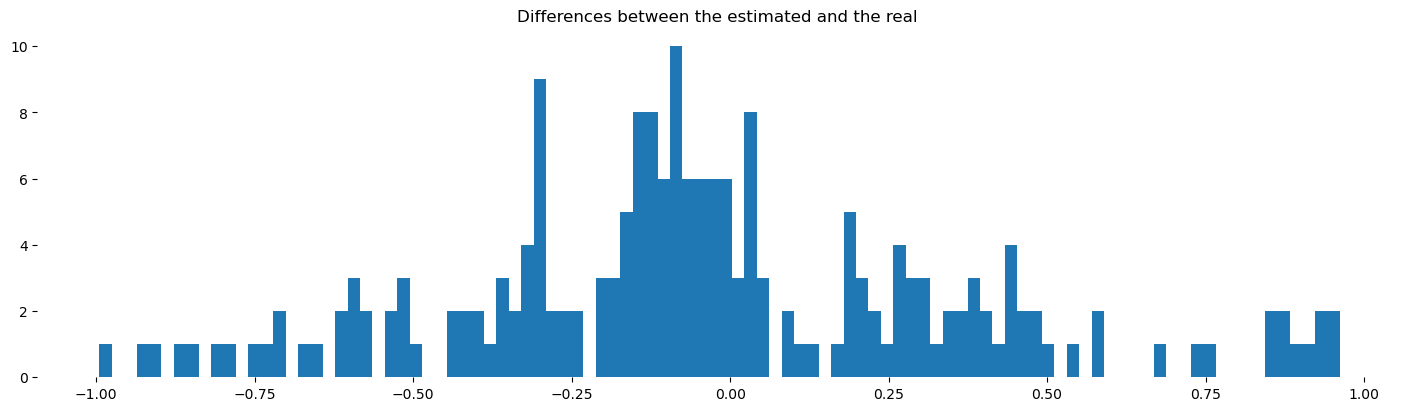

In [36]:
effect_exp = scipy.special.expit(simple_model1_idata.posterior.country_effect).mean(dim =["chain", "draw"])

summary_df = az.summary(simple_model1_idata )["mean"]

differences  = ( effect_exp - np.array(model_df_1.groupby("ISO").is_disaster.mean()) )
plt.hist(differences, bins = 100)
plt.title("Differences between the estimated and the real ");

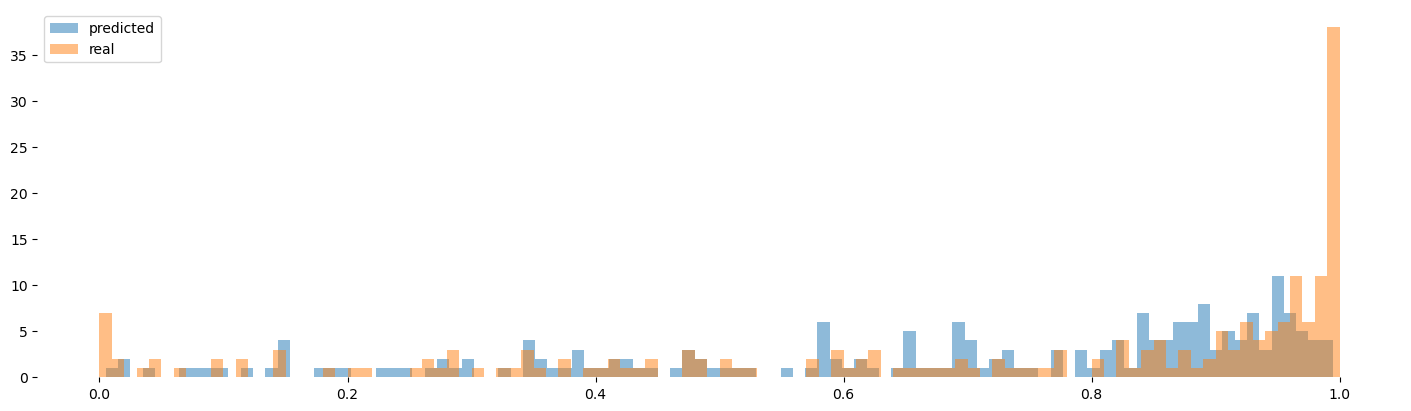

In [37]:
plt.hist(scipy.special.expit(simple_model1_idata.posterior.country_effect).mean(dim =["chain", "draw"]),
         bins = 100, alpha=0.5 , label = "predicted")

plt.hist(np.array(model_df_1.groupby("ISO").is_disaster.mean()), bins = 100,  alpha=0.5, label = "real");

plt.legend();

# Logistic regression with distance features

In [38]:
#Delimiting data set
model_list_2 = ['ISO', 'Start_Year', "is_disaster", 'log_distance_to_river', 'log_distance_to_coastline', 'is_island' ]

features_2 = ['log_distance_to_river', 'log_distance_to_coastline']

model_df_2 = merged_df5[model_list_2].dropna()

In [39]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(model_df_2["is_disaster"])
ISO_idx, ISO = pd.factorize(model_df_2["ISO"]) 
obs_idx = model_df_2.index

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(model_df_2.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords_2 = {"is_disaster" : is_disaster,
          "obs_idx": obs_idx,
             "ISO": ISO,
             "feature": features_2}


In [40]:
with pm.Model(coords=coords_2) as model_distance2:
    #Declare data
    X, Y= add_data(features= features_2 ,  target = "is_disaster", df =  model_df_2, )
    is_island = pm.Data("is_island",  model_df_2["is_island"].astype(bool), dims = ["obs_idx"] )
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    beta_sigma = [ 1, 1]
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])
    is_island_beta = pm.Normal("'is_island'", mu = 1, sigma = 1)

    #Model mu
    p = country_effect[ISO_idx] + (X * beta).sum(axis=1) + (is_island * is_island_beta)

    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')

In [41]:
#Sampling
with model_distance2:
    model_distance2_idata =sample_or_load(
            fp="model_distance2b",
            resample= False,
            sample_kwargs={
                "nuts_sampler": 'numpyro',
                "chains": 8,
                "draws": 1000,
            })

    model_distance2_idata = model_distance2_idata.assign_coords(xr_idx)

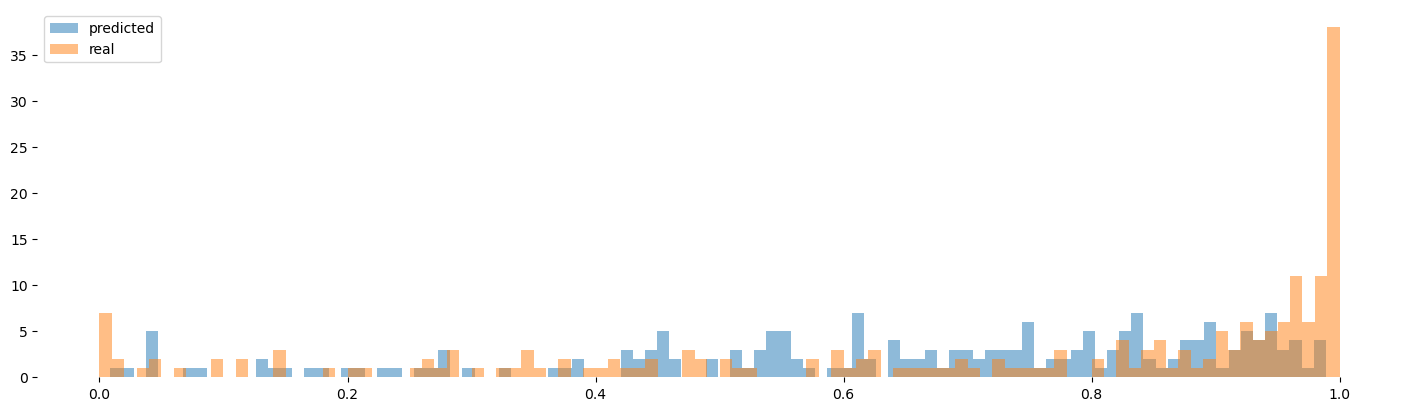

In [42]:
plt.hist(scipy.special.expit(model_distance2_idata.posterior.country_effect).mean(dim =["chain", "draw"]),
         bins = 100, alpha=0.5 , label = "predicted")

plt.hist( np.array(model_df_1.groupby("ISO").is_disaster.mean()), bins = 100,  alpha=0.5, label = "real");

plt.legend();

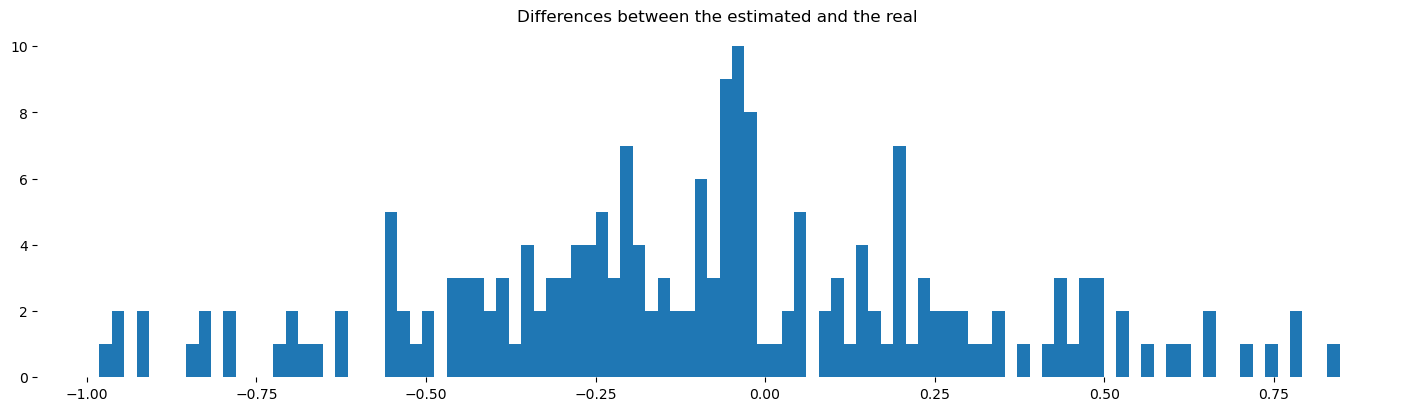

In [43]:
effect_exp = scipy.special.expit(model_distance2_idata.posterior.country_effect).mean(dim =["chain", "draw"])

summary_df = az.summary(model_distance2_idata )["mean"]

differences  = ( effect_exp - np.array(model_df_2.groupby("ISO").is_disaster.mean()) )
plt.hist(differences, bins = 100)
plt.title("Differences between the estimated and the real ");

In [44]:
az.summary(model_distance2_idata, ["~country_effect", "~country_effect_offset"])

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
'is_island'                      1.493  0.168   1.176    1.812      0.004   
beta[log_distance_to_river]     -0.384  0.015  -0.414   -0.356      0.000   
beta[log_distance_to_coastline] -0.879  0.019  -0.912   -0.842      0.000   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
'is_island'                        0.003    1505.0    2872.0   1.01  
beta[log_distance_to_river]        0.000    7566.0    6409.0   1.00  
beta[log_distance_to_coastline]    0.000    6343.0    5820.0   1.00

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


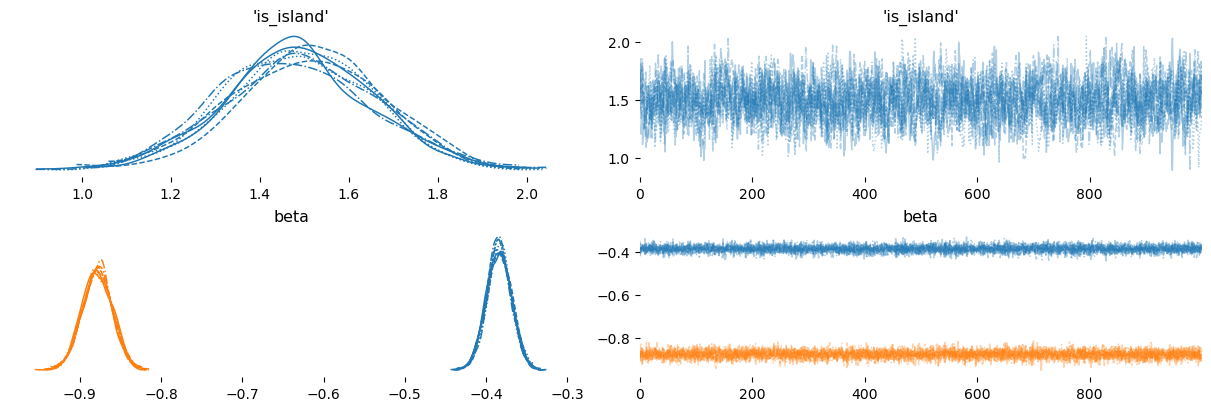

In [45]:
az.plot_trace(model_distance2_idata, var_names =  ["~country_effect", "~country_effect_offset"]);

# Logistic regression with distance and country features

In [46]:
#Delimiting data set
model_list_3 = ['ISO', 'Start_Year', "is_disaster", 'log_distance_to_river', 'log_distance_to_coastline', 'is_island',
               "Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
               'log_gdp_per_cap', 'log_gdp_per_cap_squared']

features_3 = ['log_distance_to_river', 'log_distance_to_coastline',
             "Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
             'log_gdp_per_cap', 'log_gdp_per_cap_squared']

model_df_3 = merged_df5[model_list_3].dropna()

In [47]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(model_df_3["is_disaster"])
ISO_idx, ISO = pd.factorize(model_df_3["ISO"]) 
obs_idx = model_df_3.index

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(model_df_3.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords_3 = {"is_disaster" : is_disaster,
          "obs_idx": obs_idx,
             "ISO": ISO,
             "feature": features_3}


In [48]:
with pm.Model(coords=coords_3) as model_distance3:
    #Declare data
    X, Y= add_data(features= features_3 ,  target = "is_disaster", df =  model_df_3, )
    is_island = pm.Data("is_island",  model_df_3["is_island"].astype(bool), dims = ["obs_idx"] )
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    beta_sigma = [0.1] * 1
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])
    is_island_beta = pm.Normal("'is_island'", mu = 1, sigma = 1)

    #Model mu
    p = country_effect[ISO_idx] + (X * beta).sum(axis=1) + (is_island * is_island_beta)

    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')

In [49]:
#Sampling
with model_distance3:
    model_distance3_idata =sample_or_load(
            fp="model_distance3",
            resample= False,
            sample_kwargs={
                "nuts_sampler": 'numpyro',
                "chains": 8,
                "draws": 1000,
            })

    model_distance3_idata = model_distance3_idata.assign_coords(xr_idx)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_hat]


Output()

Output()

In [50]:
az.summary(model_distance3_idata, ["~country_effect", "~country_effect_offset"])

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  \
'is_island'                           1.297  0.280   0.770    1.818   
beta[log_distance_to_river]          -0.389  0.017  -0.423   -0.357   
beta[log_distance_to_coastline]      -0.787  0.020  -0.824   -0.751   
beta[Population]                     -0.587  0.079  -0.729   -0.432   
beta[co2]                             0.830  0.022   0.790    0.872   
beta[precip_deviation]                0.149  0.022   0.108    0.190   
beta[dev_ocean_temp]                  0.246  0.014   0.219    0.273   
beta[log_population_density]          0.871  0.083   0.715    1.022   
beta[log_population_density_squared]  0.869  0.082   0.716    1.026   
beta[log_gdp_per_cap]                -0.618  0.080  -0.760   -0.462   
beta[log_gdp_per_cap_squared]        -0.617  0.079  -0.767   -0.472   

                                      mcse_mean  mcse_sd  ess_bulk  ess_tail  \
'is_island'                               0.007    0.005    1592.0    2790.0   
beta[log_distance_to_river]               0.000    0.000    8502.0    6028.0   
beta[log_distance_to_coastline]           0.000    0.000    8394.0    6849.0   
beta[Population]                          0.002    0.001    1982.0    3482.0   
beta[co2]                                 0.000    0.000    2118.0    3722.0   
beta[precip_deviation]                    0.000    0.000    9075.0    6497.0   
beta[dev_ocean_temp]                      0.000    0.000    9819.0    5959.0   
beta[log_population_density]              0.002    0.001    2664.0    4422.0   
beta[log_population_density_squared]      0.002    0.001    2852.0    4730.0   
beta[log_gdp_per_cap]                     0.002    0.001    2420.0    4583.0   
beta[log_gdp_per_cap_squared]             0.001    0.001    2787.0    4117.0   

                                      r_hat  
'is_island'                             1.0  
beta[log_distance_to_river]             1.0  
beta[log_distance_to_coastline]         1.0  
beta[Population]                        1.0  
beta[co2]                               1.0  
beta[precip_deviation]                  1.0  
beta[dev_ocean_temp]                    1.0  
beta[log_population_density]            1.0  
beta[log_population_density_squared]    1.0  
beta[log_gdp_per_cap]                   1.0  
beta[log_gdp_per_cap_squared]           1.0

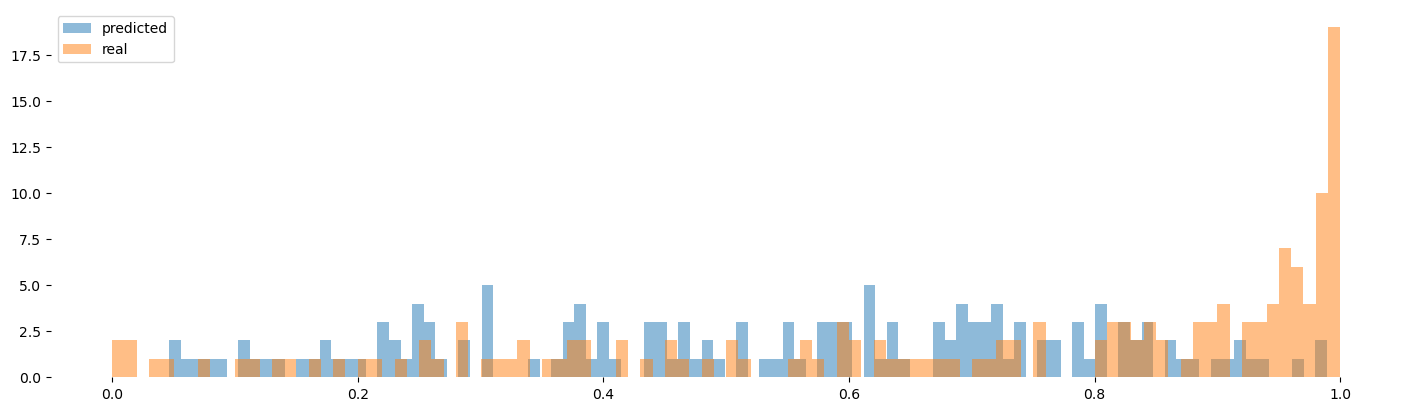

In [51]:
plt.hist(scipy.special.expit(model_distance3_idata.posterior.country_effect).mean(dim =["chain", "draw"]),
         bins = 100, alpha=0.5 , label = "predicted")

plt.hist( np.array(model_df_3.groupby("ISO").is_disaster.mean()), bins = 100,  alpha=0.5, label = "real");

plt.legend();

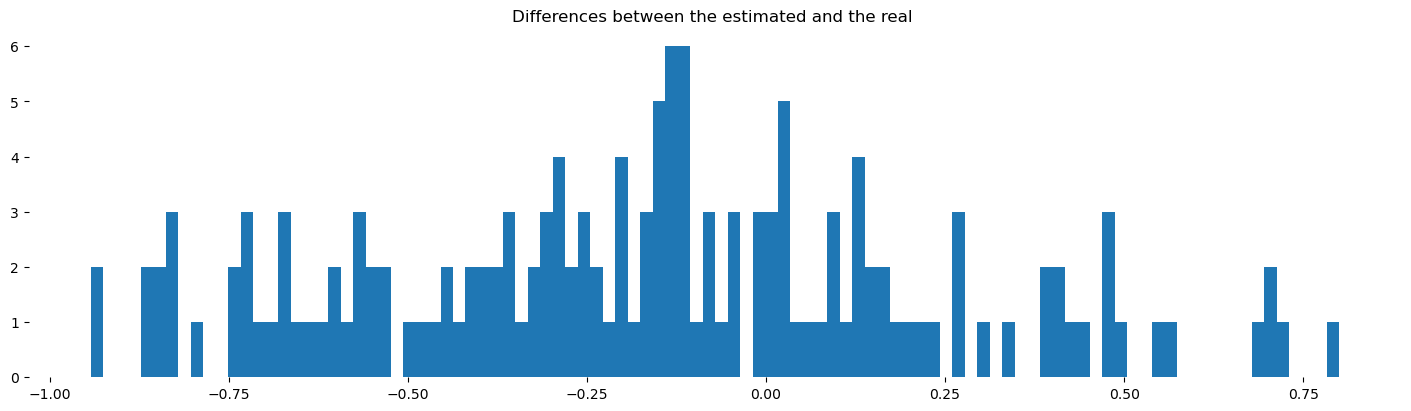

In [52]:
effect_exp = scipy.special.expit(model_distance3_idata.posterior.country_effect).mean(dim =["chain", "draw"])

summary_df = az.summary(model_distance3_idata )["mean"]

differences  = ( effect_exp - np.array(model_df_3.groupby("ISO").is_disaster.mean()) )
plt.hist(differences, bins = 100)
plt.title("Differences between the estimated and the real ");

In [53]:
predictions_model_distance3 = model_distance3_idata.posterior_predictive['y_hat'].mean(dim=['chain', 'draw'])


In [55]:
predictions_model_distance3.sel(ISO = "LAO")

<xarray.DataArray 'y_hat' (Start_Year: 108)> Size: 864B
array([0.833875, 0.86975 , 0.8805  , 0.918125, 0.8975  , 0.901875,
       0.926   , 0.89225 , 0.632375, 0.726   , 0.804125, 0.9405  ,
       0.927625, 0.837375, 0.647375, 0.84325 , 0.830625, 0.917125,
       0.759875, 0.756875, 0.930375, 0.819125, 0.90475 , 0.877625,
       0.8145  , 0.92425 , 0.92375 , 0.89725 , 0.87075 , 0.8835  ,
       0.90425 , 0.923875, 0.862125, 0.822125, 0.820625, 0.82625 ,
       0.937875, 0.899625, 0.928   , 0.899   , 0.938   , 0.950625,
       0.87825 , 0.890125, 0.955   , 0.95925 , 0.979125, 0.931625,
       0.963375, 0.8925  , 0.914125, 0.89025 , 0.967   , 0.991125,
       0.966125, 0.92775 , 0.926   , 0.924625, 0.952125, 0.956625,
       0.957875, 0.950375, 0.95325 , 0.9555  , 0.95175 , 0.957625,
       0.967625, 0.932125, 0.936375, 0.934625, 0.96225 , 0.94325 ,
       0.952625, 0.953125, 0.938875, 0.948625, 0.95275 , 0.975875,
       0.971875, 0.979625, 0.97175 , 0.922125, 0.961375, 0.90475 ,
       0.946625, 0.914125, 0.936125, 0.940125, 0.940375, 0.988   ,
       0.979375, 0.975   , 0.97275 , 0.97025 , 0.9655  , 0.992   ,
       0.97525 , 0.976625, 0.974   , 0.966125, 0.962875, 0.9655  ,
       0.993   , 0.96125 , 0.959375, 0.978   , 0.979125, 0.965125])
Coordinates:
  * Start_Year  (Start_Year) datetime64[ns] 864B 2009-01-01 ... 2020-01-01
    ISO         <U3 12B 'LAO'

# Losgistic regression with HSGP component

In [56]:
#Delimiting data set
model_list_4 = ['ISO', 'Start_Year', "is_disaster", 'log_distance_to_river', 'log_distance_to_coastline', 'is_island',
               "Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
               'log_gdp_per_cap', 'log_gdp_per_cap_squared', "lat", "long" ]

features_4 = ['log_distance_to_river', 'log_distance_to_coastline',
             "Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
             'log_gdp_per_cap', 'log_gdp_per_cap_squared']

model_df_4 = merged_df5[model_list_4].dropna()

In [57]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(model_df_4["is_disaster"])
ISO_idx, ISO = pd.factorize(model_df_4["ISO"]) 
obs_idx = model_df_4.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(model_df_4.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords_4 = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "feature": features_4,
        "gp_feature":gp_features }


In [58]:
with pm.Model(coords=coords_4) as model_distance4:
    #Declare data
    X, Y= add_data(features= features_4 ,  target = "is_disaster", df =  model_df_4, )
    is_island = pm.Data("is_island",  model_df_4["is_island"].astype(bool), dims = ["obs_idx"] )
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    beta_sigma = [0.1] * 1
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])
    is_island_beta = pm.Normal("'is_island'", mu = 1, sigma = 1)

    # HSGP process
    X_gp = pm.Data("X_gp", model_df_4[["lat", "long"]])

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2.0)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 30, 30, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd))

    #Model mu
    p = country_effect[ISO_idx] + (X * beta).sum(axis=1) + (is_island * is_island_beta) + HSGP_component

    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')

In [ ]:
#Sampling
with model_distance4:
    model_distance4_idata =sample_or_load(
            fp="model_distance4",
            resample= True,
            sample_kwargs={
                "nuts_sampler": 'numpyro',
                "chains": 8,
                "draws": 1000,
            })

    model_distance4_idata = model_distance4_idata.assign_coords(xr_idx)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
plt.hist(scipy.special.expit(model_distance3_idata.posterior.country_effect).mean(dim =["chain", "draw"]),
         bins = 100, alpha=0.5 , label = "predicted")

plt.hist( np.array(model_df_3.groupby("ISO").is_disaster.mean()), bins = 100,  alpha=0.5, label = "real");

plt.legend();

In [ ]:
effect_exp = scipy.special.expit(model_distance3_idata.posterior.country_effect).mean(dim =["chain", "draw"])

summary_df = az.summary(model_distance3_idata )["mean"]

differences  = ( effect_exp - np.array(model_df_3.groupby("ISO").is_disaster.mean()) )
plt.hist(differences, bins = 100)
plt.title("Differences between the estimated and the real ");